# Forward Elimination

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.api as sma
from statsmodels.regression.linear_model import OLS
from scipy.stats import kurtosis, skew                                          #檢驗殘差常態性
from statsmodels.stats.stattools import durbin_watson                           #檢驗殘差變異數獨立性
from sklearn import preprocessing                                               #檢驗變異數同值性
from statsmodels.stats.outliers_influence import variance_inflation_factor      #檢驗共線性
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
df = pd.read_excel("/Users/chouhouren/Desktop/論文資料_新/建模型資料/df_實際模型.xlsx")

df = df.dropna()

df = df.drop(['編號'], axis=1)

df = pd.DataFrame(df)


In [27]:
feture =[]
feture = df.drop(['新總價'], axis=1)
x = feture
y = df.新總價

In [28]:
def stepwise_selection(x, y, 
                       initial_list=[],
                       vif_value=[],
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       vif_out=10,
                       verbose=True):
    
    included = list(initial_list)
    vif_too_big=list(vif_value)
    while True:
        changed=False
        # forward step
        excluded = list(set(x.columns)-set(included)-set(vif_too_big))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            
        vif_constant = sm.add_constant(x[included])        
        f_vif=[variance_inflation_factor(vif_constant.values, j) for j in range(vif_constant.shape[1])]
        f_vif=pd.Series(f_vif,index=vif_constant.columns)
        f_vif=f_vif.iloc[1:]
        big_vif = f_vif.max()
            
            
        if big_vif > vif_out:
            changed=True
            big_vif_feature = f_vif.idxmax()
            included.remove(big_vif_feature)
            vif_too_big.append(big_vif_feature)
            #if verbose:
                #print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        
         
        if not changed:
            break
    return included

result = stepwise_selection(x, y)
len(result)

Add  新交易車位數                         with p-value 0.0
Add  建物現況格局-房                       with p-value 0.0
Add  新面積                            with p-value 0.0
Add  醫院                             with p-value 0.0
Add  捷運站出口最近實際距離                    with p-value 0.0
Add  明星國中近實際距離                      with p-value 0.0
Add  總樓層數                           with p-value 0.0
Add  飛機場                            with p-value 1.88509e-233
Add  污水處理廠                          with p-value 0.0
Add  屋齡                             with p-value 0.0
Add  明星國小最近實際距離                     with p-value 7.07525e-51
Add  大安區                            with p-value 1.72632e-29
Add  百貨公司最近實際距離                     with p-value 4.9965e-28
Add  大公園最近實際距離                      with p-value 1.68426e-33
Add  106上                           with p-value 5.70895e-15
Add  中山區                            with p-value 1.94198e-14
Add  105下                           with p-value 1.00867e-14
Add  垃圾焚化廠                         

33

drop_feature = list(set(df.columns)-set(df[result].columns))


drop_feature = pd.DataFrame(drop_feature)

drop_feature.to_excel('實際forward刪除的因子.xlsx')

#### OLS模型

In [29]:
x_train = sma.add_constant(df[result]) ## let's add an intercept (beta_0) to our model

lm2 = sm.OLS(y,x_train).fit()

#### 常態性假設檢驗

In [30]:
e=y-lm2.fittedvalues
resid_skew = skew(e)
resid_kurtosis = kurtosis(e)
print('{:40}{:.5}'.format('skewness of normal distribution:',resid_skew ))
print('{:40}{:.5}'.format('kurtosis of normal distribution:',resid_kurtosis ))

skewness of normal distribution:        0.095405
kurtosis of normal distribution:        1.2626


#### 獨立性假設檢驗

In [31]:
def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)


print('{:20}{:.5}'.format('Durbin-Watson:',dw(e)))

Durbin-Watson:      1.9064


#### 變異數同值性假設檢驗

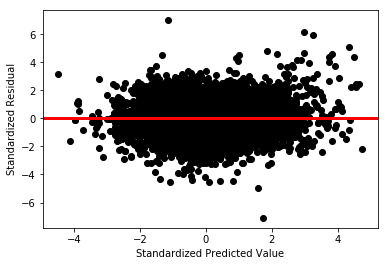

In [32]:
y_pred_norm=preprocessing.scale(lm2.fittedvalues)

e_norm =preprocessing.scale(e)


plt.scatter(y_pred_norm, e_norm,color='k',marker='o')
plt.xlabel("Standardized Predicted Value")
plt.ylabel("Standardized Residual")
plt.axhline(y=0,linewidth=3, color='r')
plt.show()

#### 無共線性檢驗

In [33]:
vif=[variance_inflation_factor(x_train.values, j) for j in range(x_train.shape[1])]
vif=pd.DataFrame(vif,index=x_train.columns,columns=['VIF'])


vif=vif.drop(['const'])
if vif['VIF'].max() <10:
    print('no collinarity')
else:
    print(vif['VIF'].argmax())

no collinarity


In [34]:
p_value = pd.DataFrame(lm2.tvalues,columns=['p_value'])

coef = pd.DataFrame(lm2.params,columns=['coef'])

vif=[variance_inflation_factor(x_train.values, j) for j in range(x_train.shape[1])]
vif=pd.DataFrame(vif,index=x_train.columns,columns=['VIF'])

In [35]:
df_逐步回歸 = pd.merge(coef,p_value,left_index=True,right_index=True).merge(vif,left_index=True,right_index=True)

#### Regression List

# K-Fold Regression Model

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.utils import check_array
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [37]:
x = np.array(df[result])
y = np.array(df['新總價'])
x = np.array([np.concatenate((v,[1])) for v in x])

In [38]:
linreg = LinearRegression(fit_intercept=False)

In [39]:
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    linreg.fit(x[train],y[train])
    p = linreg.predict(x[test])
    e = p-y[test]

In [40]:
y_test=np.exp(y[test])
p = np.exp(p)

#### MAPE

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE=mean_absolute_percentage_error(y_test,p).round(2)

#### MAE

In [42]:
MAE=mean_absolute_error(y_test, p).round(2)

#### RMSE

In [43]:
RMSE=np.sqrt(metrics.mean_squared_error(y_test,p)).round(0)

#### HIT RATE

In [44]:
def Hit_Rate_error(y_test,predict_value,alpha):
    
    df_yp=[]
    y_test=pd.DataFrame(y_test,columns=['y_test'])
    predict_value=pd.DataFrame(predict_value,columns=['predict_value'])
    df_yp = pd.concat([y_test,predict_value],axis=1)#y_test and predict_value
    命中值 =[(df_yp['predict_value']<df_yp['y_test']+df_yp['y_test']*alpha)&(df_yp['predict_value']>df_yp['y_test']-df_yp['y_test']*alpha)]
    choices = [1]
    df_yp['命中值'] = np.select(命中值,choices,default=0)
    HIT_rate = (df_yp['命中值'].sum()/len(y_test)*100).round(2)
    return HIT_rate

In [45]:
HIT_rate_10=Hit_Rate_error(y_test,p,0.1)

In [46]:
HIT_rate_20=Hit_Rate_error(y_test,p,0.2)

In [47]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, p).round(2)

In [48]:
print('{:20}{:.4}'.format('R2:', R2))
print('{:20}{:.10}'.format('MAPE:', MAPE))
print('{:20}{:.10}'.format('MAE:', MAE))
print('{:20}{:.10}'.format('RMSE:', RMSE))
print('{:20}{:.10}'.format('HIT_rate_10:', HIT_rate_10))
print('{:20}{:.10}'.format('HIT_rate_20:', HIT_rate_20))

R2:                 0.85
MAPE:               15.99
MAE:                4893383.55
RMSE:               12720307.0
HIT_rate_10:        38.4
HIT_rate_20:        69.9
